# Import Libraries

In [7]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Clear session
tf.keras.backend.clear_session()

# Set parameters
IMG_SIZE = (128, 128)  # Increased image size
BATCH_SIZE = 16  # Increased batch size
base_dir = 'E:/val'
categories = ['covid-19', 'non-covid', 'normal']


# Data Loading and Preprocessing


In [8]:
# Function to load and preprocess data
def load_and_preprocess_data(base_dir, categories, img_size):
    data = []
    labels = []
    for category in categories:
        path = os.path.join(base_dir, category, 'images')
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path)
                img_array = cv2.resize(img_array, img_size)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
                img_array = cv2.GaussianBlur(img_array, (5, 5), 0)
                img_array = cv2.equalizeHist(img_array)
                img_array = img_array / 255.0
                img_array = np.expand_dims(img_array, axis=-1)
                img_array = np.repeat(img_array, 3, axis=-1)
                data.append(img_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    return np.array(data), np.array(labels)

# Load and preprocess data
data, labels = load_and_preprocess_data(base_dir, categories, IMG_SIZE)
labels = to_categorical(labels, num_classes=len(categories))

# Check for NaN values in the data
if np.isnan(data).any() or np.isnan(labels).any():
    print("NaN values found in the data or labels. Please clean the data.")
    data = np.nan_to_num(data)
    labels = np.nan_to_num(labels)


In [9]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Function to plot training history
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


Epoch 1/10
217/217 [==============================] - 20s 69ms/step - loss: 1.3658 - accuracy: 0.5528 - val_loss: 1.3039 - val_accuracy: 0.5513 - lr: 1.0000e-05
Epoch 2/10
217/217 [==============================] - 13s 59ms/step - loss: 1.0848 - accuracy: 0.6852 - val_loss: 1.0332 - val_accuracy: 0.6897 - lr: 1.0000e-05
Epoch 3/10
217/217 [==============================] - 12s 56ms/step - loss: 0.9695 - accuracy: 0.7403 - val_loss: 1.1008 - val_accuracy: 0.6978 - lr: 1.0000e-05
Epoch 4/10
217/217 [==============================] - 12s 56ms/step - loss: 0.9039 - accuracy: 0.7611 - val_loss: 1.1145 - val_accuracy: 0.6920 - lr: 1.0000e-05
Epoch 5/10
217/217 [==============================] - 12s 56ms/step - loss: 0.8615 - accuracy: 0.7761 - val_loss: 1.0566 - val_accuracy: 0.7474 - lr: 1.0000e-05
Epoch 6/10
217/217 [==============================] - 13s 58ms/step - loss: 0.8277 - accuracy: 0.7862 - val_loss: 0.9492 - val_accuracy: 0.7255 - lr: 1.0000e-05
Epoch 7/10
217/217 [==============

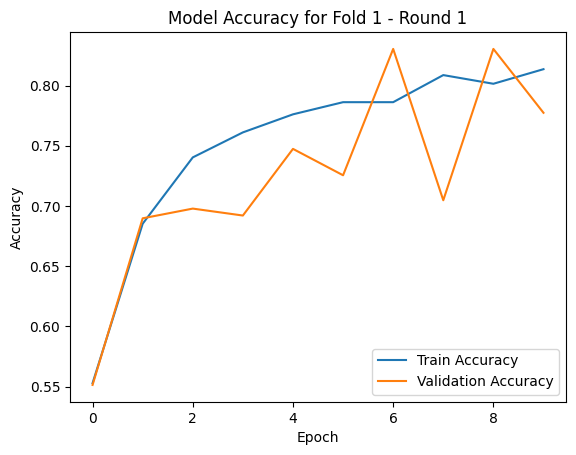

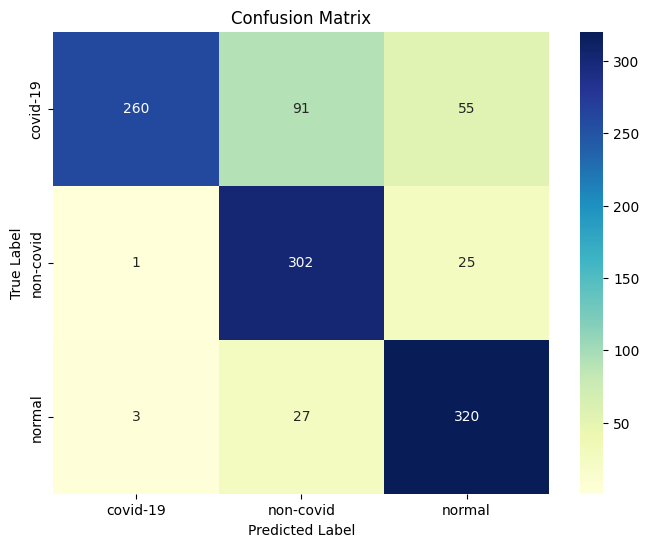

Epoch 1/10
217/217 [==============================] - 16s 62ms/step - loss: 1.3531 - accuracy: 0.5643 - val_loss: 1.1782 - val_accuracy: 0.7843 - lr: 1.0000e-05
Epoch 2/10
217/217 [==============================] - 13s 59ms/step - loss: 1.1056 - accuracy: 0.6823 - val_loss: 1.0737 - val_accuracy: 0.6863 - lr: 1.0000e-05
Epoch 3/10
217/217 [==============================] - 13s 58ms/step - loss: 1.0089 - accuracy: 0.7248 - val_loss: 0.7962 - val_accuracy: 0.8062 - lr: 1.0000e-05
Epoch 4/10
217/217 [==============================] - 12s 56ms/step - loss: 0.9363 - accuracy: 0.7406 - val_loss: 1.2943 - val_accuracy: 0.6828 - lr: 1.0000e-05
Epoch 5/10
217/217 [==============================] - 12s 56ms/step - loss: 0.8848 - accuracy: 0.7649 - val_loss: 1.2533 - val_accuracy: 0.6413 - lr: 1.0000e-05
Epoch 6/10
217/217 [==============================] - 12s 57ms/step - loss: 0.8689 - accuracy: 0.7640 - val_loss: 0.9584 - val_accuracy: 0.7682 - lr: 1.0000e-05
Epoch 7/10
217/217 [==============

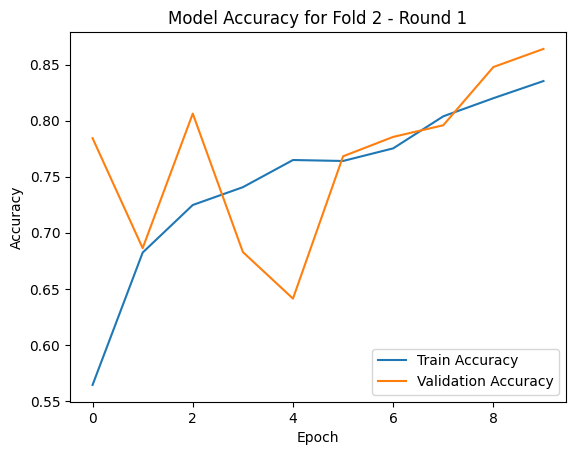

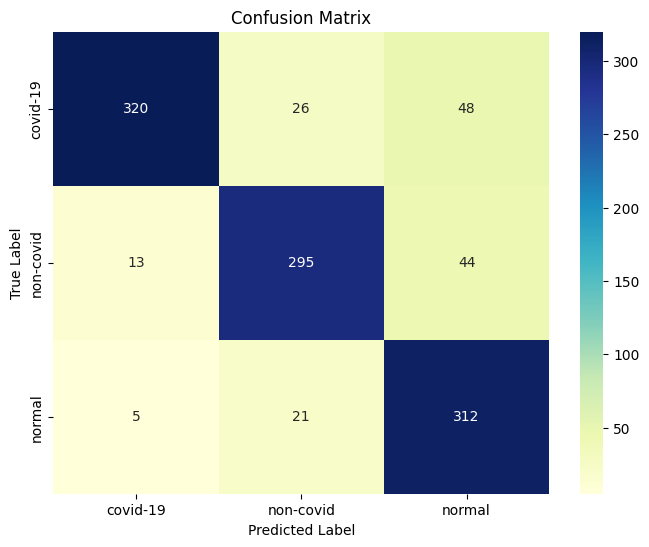

Epoch 1/10
217/217 [==============================] - 17s 67ms/step - loss: 1.3146 - accuracy: 0.5878 - val_loss: 1.0944 - val_accuracy: 0.7682 - lr: 1.0000e-05
Epoch 2/10
217/217 [==============================] - 12s 56ms/step - loss: 1.0702 - accuracy: 0.7003 - val_loss: 1.0948 - val_accuracy: 0.6932 - lr: 1.0000e-05
Epoch 3/10
217/217 [==============================] - 13s 57ms/step - loss: 0.9575 - accuracy: 0.7545 - val_loss: 0.9426 - val_accuracy: 0.7647 - lr: 1.0000e-05
Epoch 4/10
217/217 [==============================] - 13s 57ms/step - loss: 0.9099 - accuracy: 0.7684 - val_loss: 0.9069 - val_accuracy: 0.7716 - lr: 1.0000e-05
Epoch 5/10
217/217 [==============================] - 12s 56ms/step - loss: 0.8839 - accuracy: 0.7669 - val_loss: 1.0099 - val_accuracy: 0.7463 - lr: 1.0000e-05
Epoch 6/10
217/217 [==============================] - 12s 56ms/step - loss: 0.8635 - accuracy: 0.7834 - val_loss: 1.2719 - val_accuracy: 0.6909 - lr: 1.0000e-05
Epoch 7/10
217/217 [==============

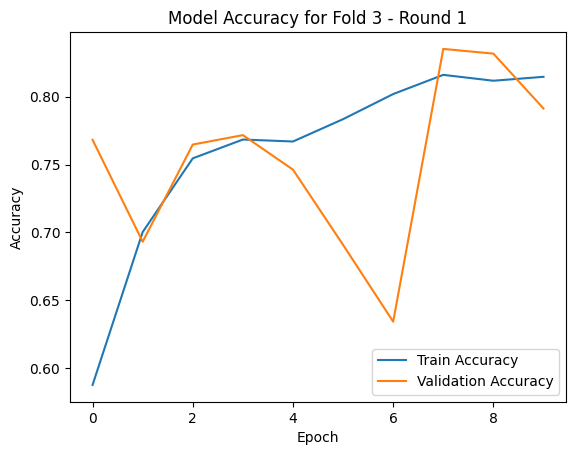

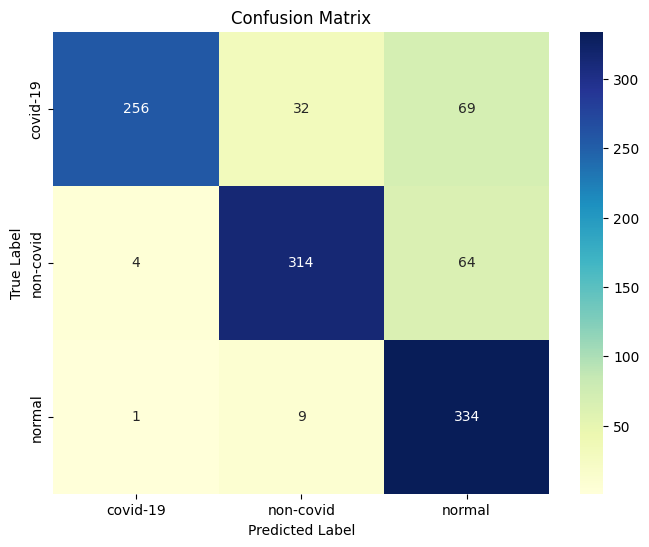

Epoch 1/10
217/217 [==============================] - 15s 59ms/step - loss: 1.3729 - accuracy: 0.5746 - val_loss: 1.1433 - val_accuracy: 0.6240 - lr: 1.0000e-05
Epoch 2/10
217/217 [==============================] - 13s 58ms/step - loss: 1.1321 - accuracy: 0.6746 - val_loss: 0.8393 - val_accuracy: 0.8085 - lr: 1.0000e-05
Epoch 3/10
217/217 [==============================] - 13s 58ms/step - loss: 1.0262 - accuracy: 0.7182 - val_loss: 0.7569 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 4/10
217/217 [==============================] - 12s 56ms/step - loss: 0.9562 - accuracy: 0.7508 - val_loss: 0.7927 - val_accuracy: 0.8005 - lr: 1.0000e-05
Epoch 5/10
217/217 [==============================] - 12s 56ms/step - loss: 0.9125 - accuracy: 0.7496 - val_loss: 0.8081 - val_accuracy: 0.7809 - lr: 1.0000e-05
Epoch 6/10
217/217 [==============================] - 12s 57ms/step - loss: 0.8758 - accuracy: 0.7716 - val_loss: 0.7484 - val_accuracy: 0.8339 - lr: 1.0000e-05
Epoch 7/10
217/217 [==============

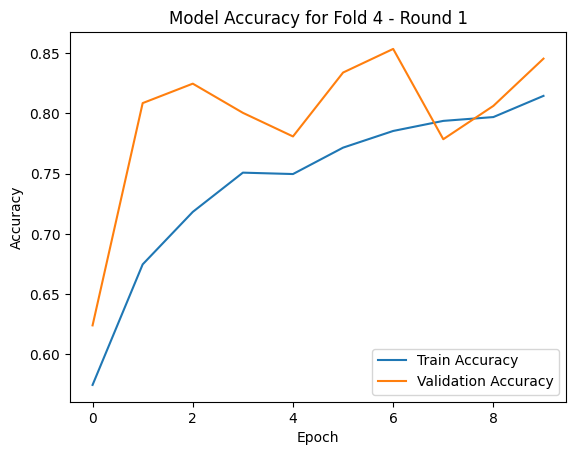

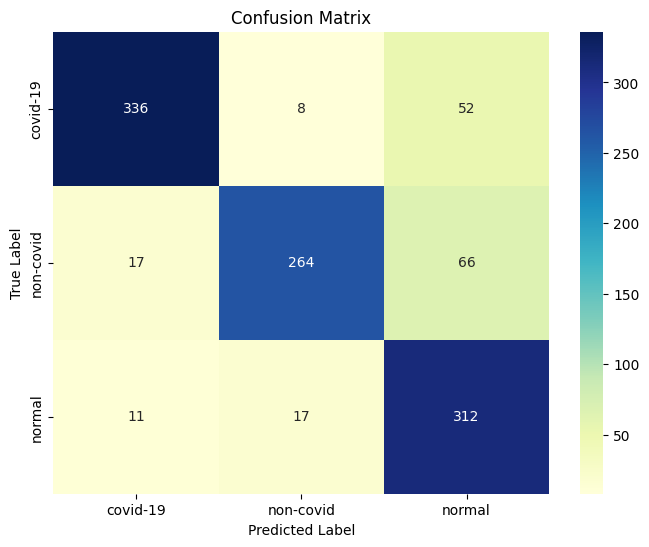

Epoch 1/10
217/217 [==============================] - 15s 61ms/step - loss: 1.3442 - accuracy: 0.5590 - val_loss: 1.2497 - val_accuracy: 0.6390 - lr: 1.0000e-05
Epoch 2/10
217/217 [==============================] - 13s 58ms/step - loss: 1.0422 - accuracy: 0.7026 - val_loss: 0.9933 - val_accuracy: 0.7463 - lr: 1.0000e-05
Epoch 3/10
217/217 [==============================] - 13s 58ms/step - loss: 0.9705 - accuracy: 0.7384 - val_loss: 0.8664 - val_accuracy: 0.7820 - lr: 1.0000e-05
Epoch 4/10
217/217 [==============================] - 13s 58ms/step - loss: 0.9013 - accuracy: 0.7603 - val_loss: 0.7703 - val_accuracy: 0.8097 - lr: 1.0000e-05
Epoch 5/10
217/217 [==============================] - 13s 58ms/step - loss: 0.8685 - accuracy: 0.7727 - val_loss: 0.7125 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 6/10
217/217 [==============================] - 13s 61ms/step - loss: 0.8308 - accuracy: 0.7863 - val_loss: 0.6988 - val_accuracy: 0.8408 - lr: 1.0000e-05
Epoch 7/10
217/217 [==============

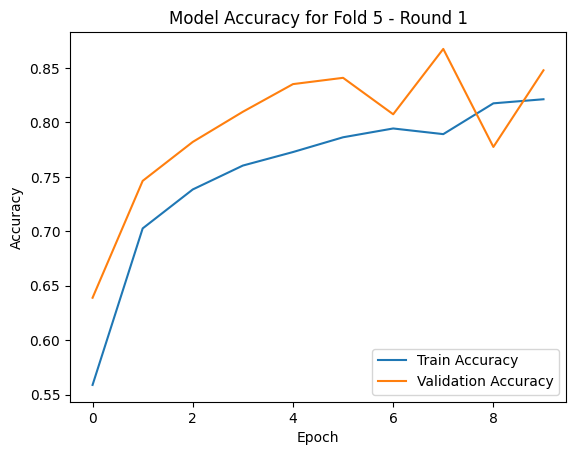

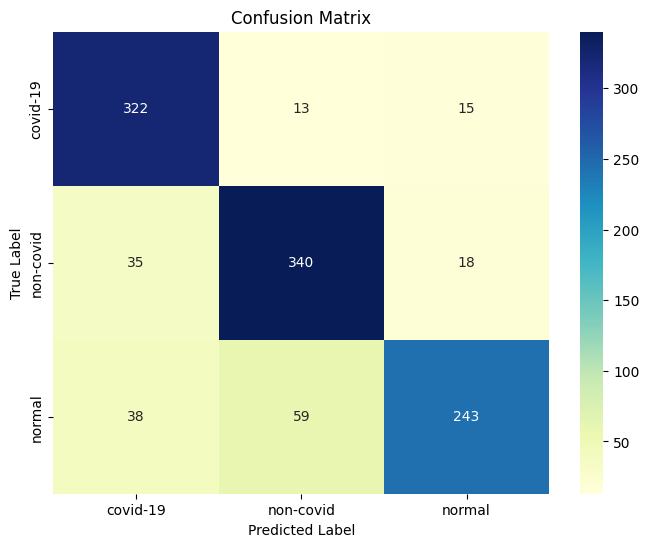

In [10]:
# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_index, test_index in kf.split(data):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Check for NaN values in the split data
    if np.isnan(x_train).any() or np.isnan(y_train).any() or np.isnan(x_test).any() or np.isnan(y_test).any():
        print(f"NaN values found in fold {fold}. Cleaning data...")
        x_train = np.nan_to_num(x_train)
        y_train = np.nan_to_num(y_train)
        x_test = np.nan_to_num(x_test)
        y_test = np.nan_to_num(y_test)

    # Split data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
    val_generator = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)
    test_generator = test_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE)

    # CNN Implementation
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    # Unfreeze top layers for fine-tuning
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(categories), activation='softmax', dtype='float32')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_model_fold_{fold}_round_1.h5', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

    # Train model
    history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping, model_checkpoint, reduce_lr])

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_generator)
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    auc = roc_auc_score(y_test, y_pred, multi_class='ovo')

    # Print metrics for the fold
    print(f"Fold {fold} - Round 1")
    print("Confusion Matrix:")
    print(cm)
    print("AUC Score:", auc)
    print("Test Accuracy:", test_accuracy)

    # Plot training history
    plot_history(history, f"Model Accuracy for Fold {fold} - Round 1")

    # Plot the confusion matrix for the fold
    plot_confusion_matrix(cm, categories)
    
    # Clear session to free memory
    tf.keras.backend.clear_session()
    fold += 1


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


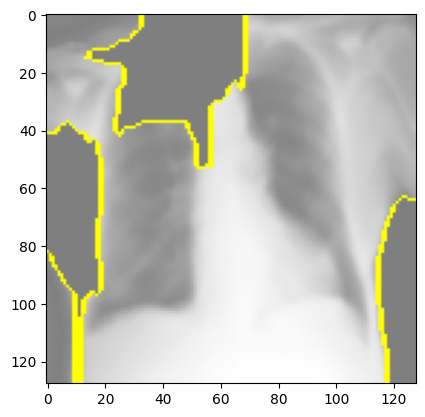

In [16]:
# Assuming 'x_test' contains your image data and 'model' is your trained model
test_image_index = 0  # Example: Choose the first image from the test set
test_image_array = x_test[test_image_index]

from lime import lime_image
explainer = lime_image.LimeImageExplainer()

# Explaining an instance
explanation = explainer.explain_instance(
    image=test_image_array, 
    classifier_fn=model.predict, 
    top_labels=5, 
    hide_color=0, 
    num_samples=1000 # Number of perturbed images to use
)

# Displaying the image with explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=10, 
    hide_rest=True
)

import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()
